In [1]:
import os
import sys
from osgeo import gdal, ogr
from math import ceil
import geopandas
import pandas as pd
from pyproj import Proj, transform
import numpy as np
from shapely.geometry import Point
#from IPython.core.debugger import set_trace
##python evaluation.py dank.shp -11724369.15 -11644519.67 4810066.59 4852046.60 100 100
def create_grid(outputGridfn, xmin, xmax, ymin, ymax, gridHeight, gridWidth):

    # convert sys.argv to float
    xmin = float(xmin)
    xmax = float(xmax)
    ymin = float(ymin)
    ymax = float(ymax)
    gridWidth = float(gridWidth)
    gridHeight = float(gridHeight)

    # get rows
    rows = ceil((ymax - ymin) / gridHeight)
    # get columns
    cols = ceil((xmax - xmin) / gridWidth)

    # start grid cell envelope
    ringXleftOrigin = xmin
    ringXrightOrigin = xmin + gridWidth
    ringYtopOrigin = ymax
    ringYbottomOrigin = ymax - gridHeight

    # create output file
    outDriver = ogr.GetDriverByName('ESRI Shapefile')
    if os.path.exists(outputGridfn):
        os.remove(outputGridfn)
    outDataSource = outDriver.CreateDataSource(outputGridfn)
    outLayer = outDataSource.CreateLayer(
        outputGridfn, geom_type=ogr.wkbPolygon)
    featureDefn = outLayer.GetLayerDefn()

    # create grid cells
    countcols = 0
    while countcols < cols:
        countcols += 1

        # reset envelope for rows
        ringYtop = ringYtopOrigin
        ringYbottom = ringYbottomOrigin
        countrows = 0

        while countrows < rows:
            countrows += 1
            ring = ogr.Geometry(ogr.wkbLinearRing)
            ring.AddPoint(ringXleftOrigin, ringYtop)
            ring.AddPoint(ringXrightOrigin, ringYtop)
            ring.AddPoint(ringXrightOrigin, ringYbottom)
            ring.AddPoint(ringXleftOrigin, ringYbottom)
            ring.AddPoint(ringXleftOrigin, ringYtop)
            poly = ogr.Geometry(ogr.wkbPolygon)
            poly.AddGeometry(ring)

            # add new geom to layer
            outFeature = ogr.Feature(featureDefn)
            outFeature.SetGeometry(poly)
            outLayer.CreateFeature(outFeature)
            outFeature.Destroy

            # new envelope for next poly
            ringYtop = ringYtop - gridHeight
            ringYbottom = ringYbottom - gridHeight

        # new envelope for next poly
        ringXleftOrigin = ringXleftOrigin + gridWidth
        ringXrightOrigin = ringXrightOrigin + gridWidth

    # Close DataSources
    outDataSource.Destroy()
    return outDataSource
grid = create_grid('dank.shp', -11724369.15, -11644519.67, 4810066.59, 4852046.60, 100, 100)

In [2]:
polys = geopandas.read_file('dank.shp')
crime_points = pd.read_csv('crime_denver_clean.csv')
data_crime = crime_points[['GEO_LON','GEO_LAT','REPORTED_DATE']]
inProj =  Proj(init='epsg:4326')
outProj = Proj(init='epsg:3857')
points = np.vectorize(transform)(inProj,outProj,data_crime['GEO_LON'], data_crime['GEO_LAT'])

In [5]:
df = pd.DataFrame({'Longitude':points[0], 'Latitude':points[1]})
df['Coordinates'] = list(zip(df.Longitude, df.Latitude))
df['Coordinates'] = df['Coordinates'].apply(Point)
points = geopandas.GeoDataFrame(df, geometry='Coordinates')

In [7]:
pointInPoly = geopandas.sjoin(points[['Coordinates']],polys[['geometry']] , op='within')
counts = pointInPoly.groupby('index_right').size()
top_polys_index=counts.sort_values(ascending=False)[:100].keys()
top_polys = polys.iloc[top_polys_index]

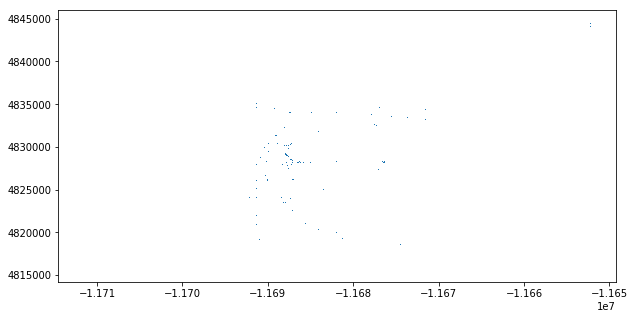

In [9]:
map_denver = top_polys.plot(figsize=(10,10))
map_denver